# АНАЛИЗ ПРОДУКТОВЫХ МЕТРИК МОБИЛЬНОГО ПРИЛОЖЕНИЯ

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.


2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.


3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

Подключим необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns
# Установка стиля Seaborn
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import chi2_contingency

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

- shared/problem1-reg_data.csv – данные о времени регистрации

In [3]:
reg_data = pd.read_csv('shared/problem1-reg_data.csv', sep = ';')
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


- shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

In [4]:
auth_data = pd.read_csv('shared/problem1-auth_data.csv', sep = ';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


### Проведём предварительный анализ данных:

- размер файлов:

In [7]:
reg_data.shape

(1000000, 2)

In [61]:
auth_data.shape

(9601013, 2)

- наличие пустых значений:

In [6]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

- типы данных:

In [8]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [9]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

- переведём столбцы со временем регистрации и захода пользователей в игру в формат datetime:

In [5]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')

In [63]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [64]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

- число уникальных пользователей:

In [13]:
reg_data.uid.nunique()

1000000

In [14]:
auth_data.uid.nunique()

1000000

Объединим два файла в один для удобства:

In [6]:
df = reg_data.merge(auth_data, on='uid')
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [66]:
df.shape

(9601013, 3)

### Описание функции cohort_retention

Функция cohort_retention предназначена для расчета удержания пользователей (retention) по когорте, основываясь на данных о регистрации и авторизации пользователей. 

#### Параметры функции:
- period: дата, начиная с которой будет производиться анализ;
- dataframe: DataFrame с данными пользователей;
- reg_date: название столбца с датами регистрации;
- auth_date: название столбца с датами авторизации;
- customer_id: название столбца с идентификаторами пользователей.

In [7]:
def cohort_retention(period, dataframe, reg_date, auth_date, customer_id):
    # Фильтрация данных: выбираются только те записи, где reg_ts больше или равна заданному периоду
    data = dataframe.query('reg_ts >= @period')
    
    data[reg_date] = data[reg_date].dt.to_period("d") # Извлекаем день регистрации
    data[auth_date] = data[auth_date].dt.to_period("d") # Извлекаем день захода в игру
    # Создаем столбец days, который содержит количество дней между датой регистрации и авторизации для каждого пользователя
    data['days'] = (data[auth_date] - data[reg_date]).apply(attrgetter('n')) 
    
    cohort_pivot = data.pivot_table(index = reg_date, columns='days', values = customer_id, aggfunc = 'nunique')
    cohort_size = cohort_pivot.iloc[:, 0] # Рассчитываем размеры когорт (первый столбец сводной таблицы)
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

    retention = (retention_matrix
            .style
            .set_caption('Daily Retention')  # Добавляем подпись
            .background_gradient(cmap='RdYlGn')  # Раскрашиваем ячейки (создаём тепловую карту)
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту

    return retention

Посмотрим на разброс дат, чтобы определить, на какой период будет рациональнее рассчитывать retention:

In [11]:
df[['reg_ts','auth_ts']].max()

reg_ts    2020-09-23 15:17:24
auth_ts   2020-09-23 15:17:24
dtype: datetime64[ns]

In [69]:
df[['reg_ts','auth_ts']].min()

reg_ts    1998-11-18 09:43:43
auth_ts   1998-11-18 09:43:43
dtype: datetime64[ns]

Нам нужно найти retention по дням от даты регистрации игрока. Видно, что разбор дат довольно большой (c 1998 по 2020 год). Таким образом, целесообразнее рассчитывать retention в рамках 1-2 недель, чтобы результаты матрицы были наглядны и понятно интерпретируемы.

##### Протестируем функцию на крайней неделе (начиная с 17 сентября 2020 года):

In [8]:
retention = cohort_retention(period="2020-09-17", dataframe=df, reg_date='reg_ts', auth_date='auth_ts', customer_id='uid')
retention

days,0,1,2,3,4,5,6
reg_ts,,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,
2020-09-19,100.00%,1.84%,3.55%,4.71%,3.49%,,
2020-09-20,100.00%,2.44%,4.34%,2.38%,,,
2020-09-21,100.00%,1.89%,2.99%,,,,
2020-09-22,100.00%,0.85%,,,,,
2020-09-23,100.00%,,,,,,


## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Попробуем сформулировать гипотезу на основе имеющихся данных:

"Если изменим (каким-то определённым образом) набор акционных предложений, то пользователи наших мобильных игр смогут быстрее увеличивать свою активность и вовлеченность за счет более привлекательных и релевантных предложений, которые будут лучше соответствовать интересам и потребностям игроков, что приведет к росту ARPU (среднего дохода на пользователя), увеличению числа платящих пользователей, увеличению конверсии в покупку (и может ещё к чему-то)". 

#### Посмотрим на данные и проведём их предварительный анализ:
Таблица с результатами A/B теста имеет три столбца:

* user_id - идентификатор пользователя
* revenue - доход с пользователя
* testgroup - группа (a либо b)

In [8]:
task2 = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
task2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [72]:
task2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [73]:
task2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [74]:
task2.shape

(404770, 3)

In [75]:
task2.user_id.nunique()

404770

##### Проверим однородность распределений тестовой и контрольных групп:

In [9]:
# Общее количество пользователей
all_users = task2.groupby('testgroup',as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'all_users'})
all_users

,testgroup,all_users
0,a,202103
1,b,202667


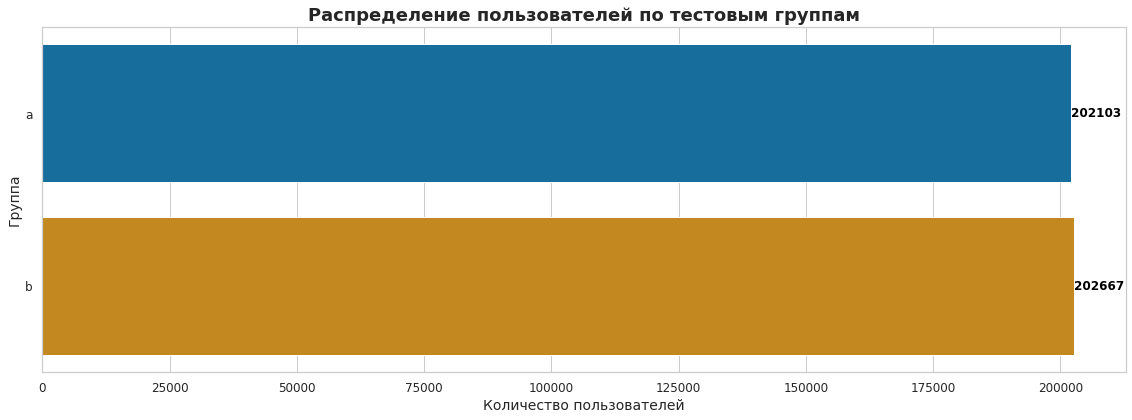

In [10]:
# Построение графика
plt.figure(figsize=(16, 6))
barplot = sns.barplot(x='all_users', y='testgroup', data=all_users, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(all_users['all_users']):
    barplot.text(value + 5, index, f'{value:}', color='black', ha='left', va='center', fontweight='bold')

# Настройка графика
plt.title('Распределение пользователей по тестовым группам', fontsize=18, fontweight='bold')
plt.xlabel('Количество пользователей', fontsize=14)
plt.ylabel('Группа', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

Количество пользователей в обеих группах примерно одинаково, это хорошо.

## Метрики:

* ### Paying Users
Найдём число платящих пользователей по группам:

In [11]:
# Количество пользователей, которые выполнили целевое действие (совершили покупку)
purchase = task2.query('revenue > 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'paying_users'})
purchase

,testgroup,paying_users
0,a,1928
1,b,1805


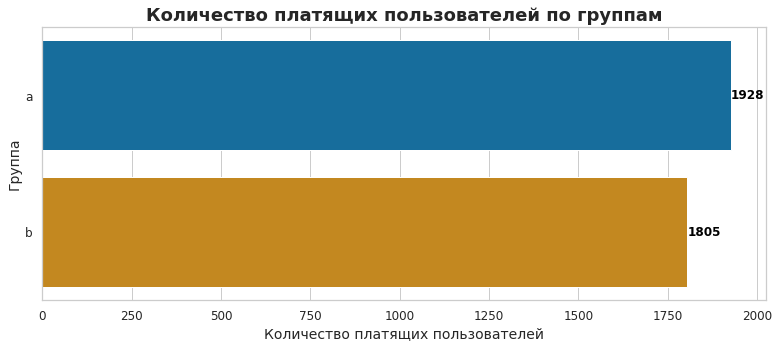

In [12]:
# Построение графика
plt.figure(figsize=(11, 5))
barplot = sns.barplot(x='paying_users', y='testgroup', data=purchase, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(purchase['paying_users']):
    barplot.text(value, index, f'{value:}', color='black', ha='left', va='center', fontweight='bold')

# Настройка графика
plt.title('Количество платящих пользователей по группам', fontsize=18, fontweight='bold')
plt.ylabel('Группа', fontsize=14)
plt.xlabel('Количество платящих пользователей', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Видно, что в контрольной группе число платящих пользователей выше, чем в тестовой (1928 - 1805 = 123 пользователя).

Это может указывать на то, что текущий набор акционных предложений в контрольной группе более эффективен в стимулировании платежной активности пользователей.

* ### Conversion Rate

Найдём конверсию в покупку:

In [13]:
# Oбъединим датафреймы 
data = all_users.merge(purchase, on='testgroup')
data

,testgroup,all_users,paying_users
0,a,202103,1928
1,b,202667,1805


In [14]:
# Посчитаем конверсию
data['conversion'] = ((data.paying_users / data.all_users) * 100).round(2)
data

,testgroup,all_users,paying_users,conversion
0,a,202103,1928,0.95
1,b,202667,1805,0.89


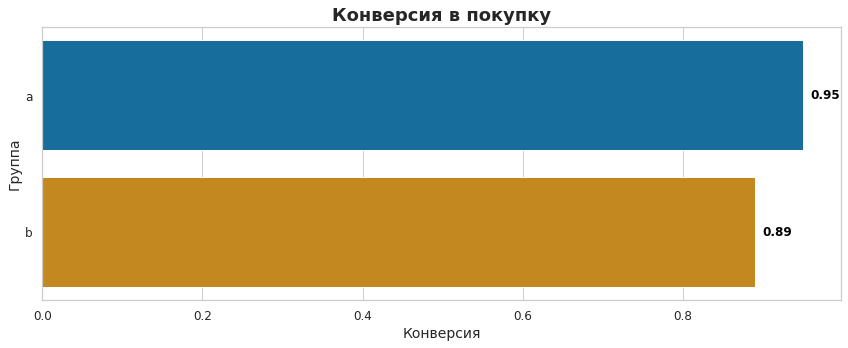

In [15]:
# Построение графика
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x='conversion', y='testgroup', data=data, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(data.conversion):
    barplot.text(value + 0.01, index, f'{value:.2f}', color='black', va='center', fontweight='bold')

# Настройка графика
plt.title('Конверсия в покупку', fontsize=18, fontweight='bold')
plt.xlabel('Конверсия', fontsize=14)
plt.ylabel('Группа', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

Конверсия в группе a больше, чем в группе b на 0,06.

Для измерения статистической значимости различий конверсий между двумя группами в A/B тестировании наиболее подходящим методом является критерий хи-квадрат. Этот тест позволяет оценить, есть ли статистически значимые различия между пропорциями двух выборок, что идеально подходит для анализа конверсий, которые представляют собой бинарные исходы (платит/не платит).

- Нулевая гипотеза: разница между средними значениями показателя в сегментах статистически незначима.

- Альтернативная гипотеза: разница между средними значениями показателя в сегментах статистически значима.

In [16]:
# Добавим новый столбец в исходный датафрейм, где будет указываться наличие/отсутствие покупки у пользователей
purchase = []
for i in task2.revenue:
    if i == 0:
        purchase.append('no')
    else:
        purchase.append('yes')
task2['purchase'] = purchase
task2.head()

,user_id,revenue,testgroup,purchase
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no


In [17]:
# Cоберем таблицу сопряженности
crosstab = pd.crosstab(task2['testgroup'], task2['purchase'])
crosstab

purchase,no,yes
testgroup,,
a,200175,1928
b,200862,1805


In [18]:
# Проведение теста хи-квадрат
chi2, p, dof, expected = chi2_contingency(crosstab)

# Вывод результатов
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

Chi-squared: 4.374729521260405
P-value: 0.03647561892312613
Degrees of freedom: 1
Expected frequencies: [[200239.10075104   1863.89924896]
 [200797.89924896   1869.10075104]]


P-value < 0.05, значит отклоняем нулевую гипотезу. 

Принимаем альтернативную гипотезу: разница между средними значениями показателя в сегментах **статистически значима**.

Можно сделать вывод о том, что набор старых акционных предложений для контрольной группы a положительно влияет на пользователей, побуждая их совершать покупки. Набор новых предложений для группы b действительно снижает конверсию в покупку.

##### Revenue
Рассмотрим распределение revenue по группам с помошью построения графика "яшик с усами", чтобы изучить подробнее различия между группами по доходу, найти интересные закономерности: 

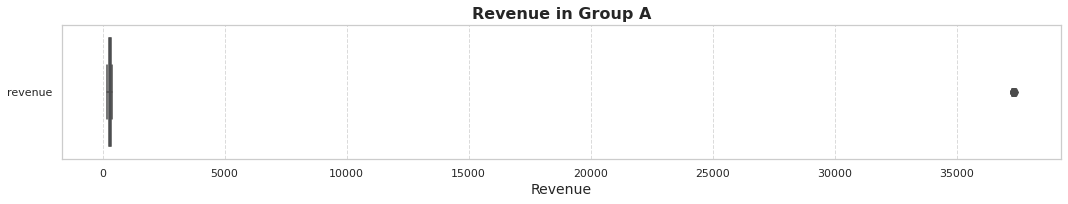

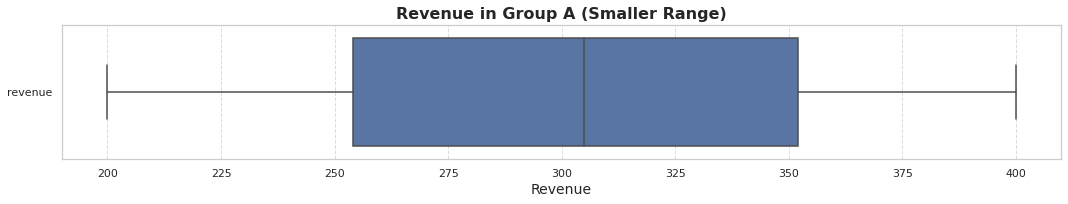

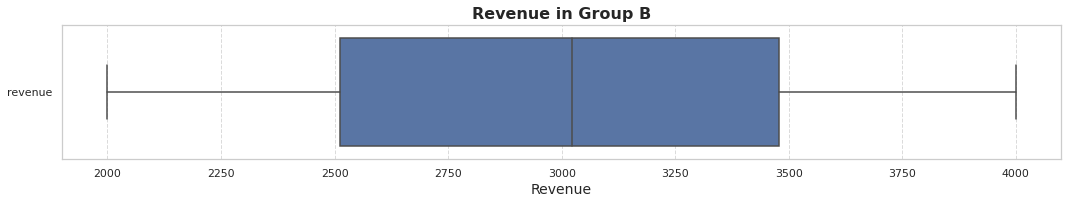

Минимальный доход в группе a: 200 
Медианный доход в группе a: 311.0 
Максимальный доход в группе a: 37433 

Минимальный доход в группе b: 2000 
Медианный доход в группе b: 3022.0 
Максимальный доход в группе b: 4000


In [19]:
# График 1: Revenue in group a
plt.figure(figsize=(15, 3))
sns.boxplot(data=task2.query("testgroup == 'a' & revenue > 0")[['revenue']], orient="h")
plt.title('Revenue in Group A', fontsize=16, fontweight='bold')
plt.xlabel('Revenue', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# График 2: Revenue in group a (smaller range)
plt.figure(figsize=(15, 3))
sns.boxplot(data=task2.query("testgroup == 'a' & 0 < revenue < 10000")[['revenue']], orient="h")
plt.title('Revenue in Group A (Smaller Range)', fontsize=16, fontweight='bold')
plt.xlabel('Revenue', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# График 3: Revenue in group b
plt.figure(figsize=(15, 3))
sns.boxplot(data=task2.query("testgroup == 'b' & revenue > 0")[['revenue']], orient="h")
plt.title('Revenue in Group B', fontsize=16, fontweight='bold')
plt.xlabel('Revenue', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(
'Минимальный доход в группе a:',task2.query('testgroup == "a" & revenue > 0')['revenue'].min(),   
'\nМедианный доход в группе a:',task2.query('testgroup == "a" & revenue > 0')['revenue'].median(),   
'\nМаксимальный доход в группе a:',task2.query('testgroup == "a" & revenue > 0')['revenue'].max(),

'\n\nМинимальный доход в группе b:',task2.query('testgroup == "b" & revenue > 0')['revenue'].min(),  
'\nМедианный доход в группе b:',task2.query('testgroup == "b" & revenue > 0')['revenue'].median(), 
'\nМаксимальный доход в группе b:',task2.query('testgroup == "b" & revenue > 0')['revenue'].max()
)

По графику сразу заметно, что диапазон значений revenue в группе а намного меньше, чем в группе b, поэтому для наглядности был выведен график с меньшим разбросом (Revenue in group a (smaller range)). 

Медианное значение дохода в группе a примерно в 10 раз меньше, чем в группе b. 

В группе а большинство покупок имеют стоимость 200 - 400 денежных единиц, однако имеются слишком дорогие покупки (максимальный доход в группе a: 37433), что говорит о неравномерности распределения. Этот момент стоит изучить глубже на наличие багов и других возможных причин таких значений. 
В группе b подобных аномалий не наблюдается.

Посмотрим на суммарный доход в распределении по группам а и b:

In [20]:
revenue = task2.groupby('testgroup', as_index = False) \
    .agg(revenue =('revenue', 'sum')) \
    .round(2)
revenue

,testgroup,revenue
0,a,5136189
1,b,5421603


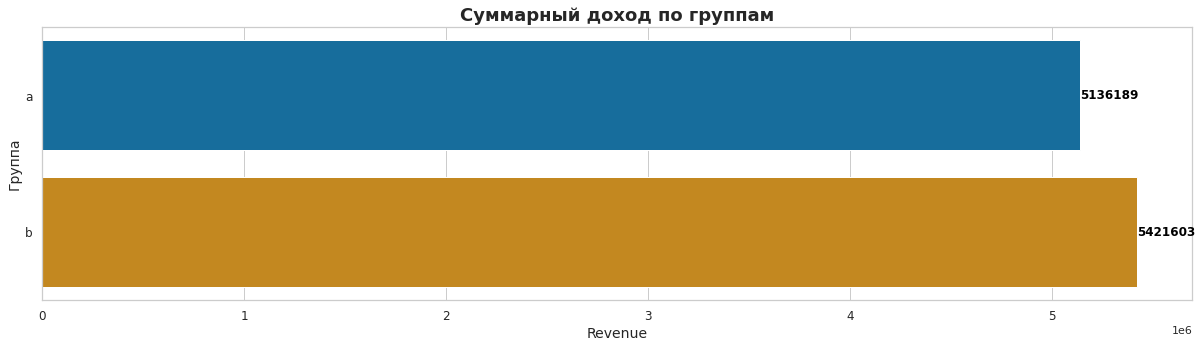

In [21]:
# Построение графика
plt.figure(figsize=(17, 5))
barplot = sns.barplot(x='revenue', y='testgroup', data=revenue, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(revenue['revenue']):
    barplot.text(value + 0.02, index, f'{value:.0f}', color='black', ha='left', va='center', fontweight='bold')

# Настройка графика
plt.title('Суммарный доход по группам', fontsize=18, fontweight='bold')
plt.xlabel('Revenue', fontsize=14)
plt.ylabel('Группа', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

In [22]:
print('Разница revenue в группах:', (abs(revenue.revenue[0] - revenue.revenue[1])/revenue.revenue[0]*100).round(),'%')

Разница revenue в группах: 6.0 %


Видно, что несмотря на меньшее число платящих пользователей и меньшую конверсию в покупку по сравнению с контрольной группом, в тестовой группе суммарный доход выше на 6% (или на 285414 денежных единиц). Это говорит о том, что в тестовой группе меньшее число покупателей совершает покупки по большей стоимости.

Проверим распределения revenue по группам на нормальность с помошью stats.normaltest:

In [23]:
print(stats.normaltest(task2.query("testgroup == 'a' & revenue>0")[['revenue']]))
print(stats.normaltest(task2.query("testgroup == 'b' & revenue>0")[['revenue']]))

NormaltestResult(statistic=array([1394.94578431]), pvalue=array([1.23416055e-303]))
NormaltestResult(statistic=array([1068.86000844]), pvalue=array([7.94324949e-233]))


Рvalue в обоих случаях меньше 0.05, значит распределения ненормальные, что было ожидаемо.

Несмотря на то что размер выборок примерно одинаков, разброс значений revenue сильно различается, значит при проведении тестов на статистическую значимость различий в ARPU и ARPPU будем использовать поправку Уэлча в t-критерии.

- ### ARPU (Average Revenue Per User) 

ARPU измеряет средний доход на пользователя и включает всех пользователей, как платящих, так и неплатящих.

Найдём средний доход на пользователя:

In [25]:
arpu = task2.groupby('testgroup', as_index = False) \
    .agg(arpu =('revenue', 'mean')) \
    .round(2)
arpu

,testgroup,arpu
0,a,25.41
1,b,26.75


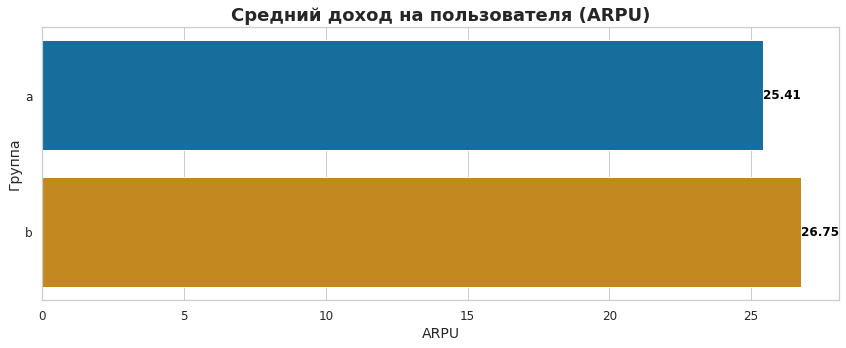

In [26]:
# Построение графика
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x='arpu', y='testgroup', data=arpu, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(arpu['arpu']):
    barplot.text(value + 0.02, index, f'{value:.2f}', color='black', ha='left', va='center', fontweight='bold')

# Настройка графика
plt.title('Средний доход на пользователя (ARPU)', fontsize=18, fontweight='bold')
plt.xlabel('ARPU', fontsize=14)
plt.ylabel('Группа', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

In [27]:
print('Разница (%) ARPU в группах:', (abs(arpu.arpu[0] - arpu.arpu[1])/arpu.arpu[0]*100).round(),'%')

Разница (%) ARPU в группах: 5.0 %


По графику видно, что средний доход на одного пользователя в тестовой группе выше на 5% (или на 1,34 денежных единиц), однако статистическая значимость данного наблюдения ещё не доказана.

Проведём U-теста Манна-Уитни и t-тест Уэлча, чтобы проверить наличие статистической значимости различий среднего дохода на пользователя по группам.

- Нулевая гипотеза: нет статистически значимой разницы значений среднего дохода в группах а и b.

- Альтернативная гипотеза: есть статистически значимая разница значений среднего дохода в группах a и b.

In [28]:
# Извлечение ARPU для каждой группы
group1_arpu = task2[task2['testgroup'] == arpu['testgroup'].iloc[0]]['revenue']
group2_arpu = task2[task2['testgroup'] == arpu['testgroup'].iloc[1]]['revenue']

In [29]:
# Проведение U-теста Манна-Уитни
stat, p_value = stats.mannwhitneyu(group1_arpu, group2_arpu)

print('U-тест Манна-Уитни:')
print('Статистика:', stat)
print('pvalue:', p_value)

U-тест Манна-Уитни:
Статистика: 20491259376.0
pvalue: 0.06269701316074398


Pvalue > 0.05, значит у нас нет оснований отклонить нулевую гипотезу, то есть нет статистически значимой разницы.

In [30]:
# Проведение t-теста Уэлча
stat, p_value = stats.ttest_ind(group1_arpu, group2_arpu, equal_var = False)

print('t-тест Уэлча:')
print('Статистика:', stat)
print('pvalue:', p_value)

t-тест Уэлча:
Статистика: -0.6234876562792212
pvalue: 0.5329647014130866


Pvalue > 0.05, значит у нас нет оснований отклонить нулевую гипотезу, то есть нет статистически значимой разницы. Однако стоит учесть, что в данном тесте pvalue очень близко к уровню значимости.

- ### ARPPU (Average Revenue Per Paying User)

ARPPU измеряет средний доход на **платящего** пользователя и учитывает только тех пользователей, которые сделали хотя бы одну покупку. 

Найдём средний доход на платящего пользователя:

In [31]:
arppu = task2.query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg(arppu =('revenue', 'mean')) \
    .round(2)
arppu

,testgroup,arppu
0,a,2664.00
1,b,3003.66


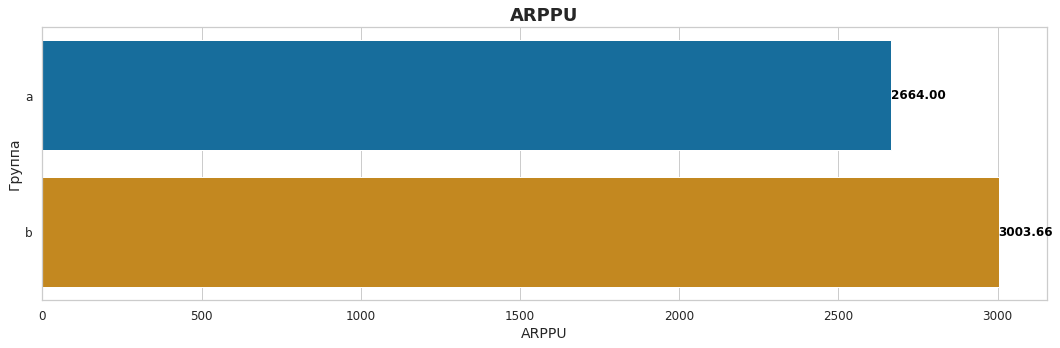

In [32]:
# Построение графика
plt.figure(figsize=(15, 5))
barplot = sns.barplot(x='arppu', y='testgroup', data=arppu, palette='colorblind')

# Добавление значений на график
for index, value in enumerate(arppu['arppu']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha='left', va='center', fontsize=12, fontweight='bold')

# Настройка графика
plt.title('ARPPU', fontsize=18, fontweight='bold')
plt.ylabel('Группа', fontsize=14)
plt.xlabel('ARPPU', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Показать график
plt.show()

 средний доход на платящего пользователя

In [33]:
print('Разница (%) ARPPU в группах:', (abs(arppu.arppu[0] - arppu.arppu[1])/arppu.arppu[0]*100).round())

Разница (%) ARPPU в группах: 13.0


По графику видно, что средний доход на одного платящего пользователя в тестовой группе выше на 13% (или на 339,66 денежных единиц), однако статистическая значимость данного наблюдения ещё не доказана.

Проведём U-теста Манна-Уитни и t-тест Уэлча, чтобы проверить наличие статистической значимости различий среднего дохода на платящего пользователя по группам.

- Нулевая гипотеза: нет статистически значимой разницы значений среднего дохода на одного платящего пользователя  в группах а и b.

- Альтернативная гипотеза: есть статистически значимая разница значений среднего дохода на одного платящего пользователя в группах a и b.

In [34]:
# Извлечение ARPPU для каждой группы
group1_arppu = task2[task2['testgroup'] == arppu['testgroup'].iloc[0]]['revenue']
group2_arppu = task2[task2['testgroup'] == arppu['testgroup'].iloc[1]]['revenue']

In [35]:
# Проведение U-теста Манна-Уитни
stat, p_value = stats.mannwhitneyu(group1_arppu, group2_arppu)

print('U-тест Манна-Уитни:')
print('Статистика:', stat)
print('pvalue:', p_value)

U-тест Манна-Уитни:
Статистика: 20491259376.0
pvalue: 0.06269701316074398


Pvalue > 0.05, значит у нас нет оснований отклонить нулевую гипотезу, то есть нет статистически значимой разницы.

In [36]:
# Проведение t-теста Уэлча
stat, p_value = stats.ttest_ind(group1_arppu, group2_arppu, equal_var = False)

print('t-тест Уэлча:')
print('Статистика:', stat)
print('pvalue:', p_value)

t-тест Уэлча:
Статистика: -0.6234876562792212
pvalue: 0.5329647014130866


Pvalue > 0.05, значит у нас нет оснований отклонить нулевую гипотезу, то есть нет статистически значимой разницы.

### Какой набор предложений можно считать лучшим?

#### Итак, что мы имеем:

- **Число платящих пользователей**: в контрольной группе a число платящих пользователей выше, чем в тестовой группе b. Это может указывать на то, что текущий набор акционных предложений в контрольной группе более эффективен в стимулировании платежной активности пользователей.

- **Конверсия в покупку**: конверсия в группе a больше, чем в группе b на 0,06. Данная разница статистически значима. Можно сделать вывод о том, что набор старых акционных предложений для контрольной группы положительно влияет на пользователей, побуждая их совершать покупки. Набор новых предложений для группы b действительно снижает конверсию в покупку.

- **Revenue**: 
  * Диапазон большинства значений revenue в группе а намного меньше, чем в группе b. Медианное значение дохода в группе a примерно в 10 раз меньше, чем в группе b. 
  * В группе а большинство покупок имеют стоимость 200-400 денежных единиц, однако имеются и слишком дорогие покупки, что говорит о неравномерности распределения. В группе b подобных аномалий не наблюдается. 
  * Несмотря на меньшее число платящих пользователей и меньшую конверсию в покупку по сравнению с контрольной группой, в тестовой группе суммарный доход выше на 6% (или на 285414 денежных единиц). Это говорит о том, что в тестовой группе меньшее число покупателей совершает покупки по большей стоимости. Обратная ситуация наблюдается в контрольной группе: большее число покупателей совершает покупки по меньшей стоимости.

- **ARPU & ARPPU**: набор акционных предложений для групп a и b не оказал статистически значимого влияния на ARPPU и ARPU.

#### Вывод:

* **Контрольная группа (группа a)** демонстрирует более высокую конверсию и большее количество платящих пользователей, что указывает на эффективность текущих акционных предложений.

* **Тестовая группа (группа b)**, несмотря на меньшее количество платящих пользователей, показывает более высокий суммарный доход благодаря более крупным покупкам.

#### Рекомендации

Если целью компании является увеличение числа платящих пользователей и конверсии, то стоит рассмотреть возможность улучшения акционных предложений в тестовой группе b, чтобы они стали более привлекательными для пользователей. Если же цель заключается в увеличении общего дохода, то текущие предложения в группе b могут быть более эффективными, несмотря на меньшую конверсию.

Таким образом, лучшим набором предложений следует считать тот, который наиболее соответствует текущим бизнес-целям компании: если это увеличение числа платящих пользователей — группа a, если это увеличение общего дохода — группа b.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Метрики для оценки результатов события

Для оценки результатов последнего прошедшего события в игре Plants & Gardens можно использовать следующие метрики:

1. **Дневная аудитория (DAU)** — количество уникальных пользователей, которые зашли в игру в течение суток. С помощью этой метрики можно сравнить количество пользователей в дни тематических событий и в обычные дни. 

2. **Процент завершения**: Доля игроков, которые успешно завершили все уровни события. Это даст представление о сложности уровней и вовлеченности игроков.

3. **Среднее время прохождения**: Время, затраченное игроками на завершение всех уровней события. Это поможет оценить, насколько эффективно игроки справлялись с задачами.

4. Обратная связь от игроков: Опросы или отзывы, собранные после события, могут дать ценную информацию о том, что игроки думают о сложности и интересности событий.

### Изменения в метриках при усложнении механики

На мой взгляд, наличие возврата назад и необходимость пользователю начинать все с нуля негативно скажется на показателях. Особенно если прохождение уровней окажется сложным. Если у пользователя мотивация будет низкой, а достижение результата слишком трудоемким, ему просто не захочется участвовать в этом процессе. Поэтому помимо вышеупомянутых показателей стоит добавить следующие:

1. **Среднее количество откатов**: Среднее количество уровней, на которые игроки откатываются после неудачи. Это поможет понять, насколько сильно усложнение механики влияет на игровой процесс.

3. **Время на восстановление**: Время, необходимое игрокам для повторного прохождения уровней после отката. Это может дать представление о том, насколько энергозатратням стало событие.

4. **Retention** - метрика, которая показывает, как пользователи возвращаются в продукт.